# Sea ice thickness retrieval implementation
## Introduction
The retrieval uses the fitted parameters from individual fits of ice thickness to brightness temperatures and a minimization scheme including uncertainties using the error covariance matrix of $T_{b,h}$ and $T_{b_v}$ at 1.4 GHz. In contrast to the original Huntemann et al. 2014 retrieval, the upper limit is not determined capped but left open, very loosely constrained by a background ice thickness. For comparison the original fit parameters from Huntemann et al. 2014 in the lastest version are used for comparison and evaluation. However, the original parameters where obtained for an incidence angle range from 40° to 50° while the new fit parameters were obtained to match the CIMR incidence angle of 53°. The equations used for their fits are {eq}`eq:intensity` and {eq}`eq:poldiff`. {eq}`eq:intensity` is also used for fitting horizontal and vertical polarization directly to the ice thickness dependence. The inversion of this system in the $H$ and $V$ space is used to optain the ice thickness.


In [1]:
using Pkg
Pkg.activate("../sit_atbd_env_jl")
#using Plots
using LaTeXStrings
using Optim
using ForwardDiff
import YAML
using Markdown
using Printf
using StaticArrays

  Activating project at `~/SeaIceThickness_ATBD/sit_atbd_env_jl`


In [2]:
#python stuff
using PythonCall
mpl=pyimport("matplotlib")
#mpl.use("Agg")
mpl.use("svg")
#mpl.use("module://juliacall.matplotlib") #some workaround for inline plotting
plt=pyimport("matplotlib.pyplot")

Python module: <module 'matplotlib.pyplot' from '/Users/huntemann/SeaIceThickness_ATBD/sit_atbd_env_jl/.CondaPkg/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [3]:
I(p)=f(x)=p[2]-(p[2]-p[1])*exp(-x/p[3])
Q(p)=f(x)=p[2]-(p[2]-p[1])*exp(-(x/p[3])^p[4])


#reading fit parameters from file

fI(x)=I(pI)(x)
fQ(x)=Q(pQ)(x)

params=YAML.load_file("fit_params.yml")
const tbh_params,tbv_params,pI,pQ=getindex.(Ref(params),["ph","pv","pI","pQ"])


ff(p)=return f(x)=p[2]-(p[2]-p[1])*exp(-x/p[3])
sit_h=ff(tbh_params)
sit_v=ff(tbv_params)

Fw_TB(x,p)=SA[ff(p[1])(x), ff(p[2])(x)]
Fw_IQ(x)=[fI(x[1]), fQ(x[1])]

Fw_TB(x)=Fw_TB(x[1],(tbh_params,tbv_params))

Fw_TB (generic function with 2 methods)

in Table {numref}`retrieval parameters` the fitted values were shown which are used for the inversion.

## retrieval definition
The retrieval is following a typical scheme with the objective to minimize

$$
χ^2(\mathbf y,\mathbf x,\mathbf S_e,\mathbf S_a,\mathbf x_a)=\left(\mathbf y-F(\mathbf x)\right)^\mathbf{T}\mathbf S_e^{-1}(\mathbf y-F(\mathbf x))+(\mathbf x_a-\mathbf x)^{\mathbf T}\mathbf S_a^{-1}(\mathbf x_a - \mathbf x) 
$$ (eq:chi2)

where $\mathbf y= \begin{bmatrix}T_{b,h}\\T_{b,v}\end{bmatrix}$ is the vector of input (measured) brightness temperatures, $\mathbf x$ is the result vector (in case of the retrieval of only one quantity, ice thickness, this is a scalar),  $\mathbf S_e$ is the error covariance matrix of the input brightness temperatures, $\mathbf S_a$ is the covariance matrix of the background values (in this case a scalar), $\textbf x_a$ is the background value (ice thickness) and $F$ is the forward operator, in our caes the individual fit function for a given ice thickness, i.e., 
$F(\mathbf x) = \begin{bmatrix}f_h(\mathbf x)\\ f_v(\mathbf x)\end{bmatrix}$

The optimal solution $\hat {\mathbf y}$ which minimizes equation {eq}`eq:chi2` is found by iteration. 
The uncertainty of $\mathbf y$ can then be obtained as 

$$
\mathbf {\hat S}_a= (\mathbf S_a^{-1}+\mathbf{ \hat M}^\mathbf T \mathbf S_e^{-1}\mathbf {\hat M})^{-1}, 
$$ (eq:error)

with $\mathbf {\hat M}$ is the Jacobian of the optimal solution of {eq}`eq:chi2` which is in this case also a scalar.

Some variables are fixed in this scheme, this is the background ice thickness $\mathbf x_a=x_a=100$ cm and its variance $\mathbf S_a=S_a=20000\ cm^2$ which is practically used to very loosly contrain the ice thickness. Others parameters are obtained from the CIMR satellite like $\mathbf y= \begin{bmatrix}T_{b,h}\\T_{b,v}\end{bmatrix}$, the brightness temperatures at L-band, and the diagonal components of the error covariance matrix $\mathbf S_a$, for the offdiagonal of $\mathbf S_a$ there is no good estimate, but it is not expected that the uncertainties of $T_{b,h}$ and $T_{b,v}$ are uncorrelated. For the lack of a better estimate, we claim a correlation of 0.6 which results in off diagonal elements of $0.6*\sigma_{Tbh}\sigma_{TBv}$. For illustration of the algorithm we use 

$$
\mathbf S_e = \begin{bmatrix}25 & 15\\ 15 & 25\end{bmatrix}
$$ (eq:tberror)


In [4]:
function retrieval(Ta,Se,Sa,xa,F)
    # easy retrieval method
    # Ta is a vector of length of input for one single retrieval length N
    # Se is the error covariance matrix of the input, i.e. length N x N
    # Sa is the error covariance matrix of the output, i.e. length M x M (the error of the background value)
    # xa is a background value where Sa is the error of, i.e. a vector of length M
    # F is a forward model receiving a input vector of length N and return an output of length M
    # ymin and ymax are the limits of the oupt regime where ot search in, both are of length M
    # returns Y, the output vector
    
    #defining error function to menimize as χ² 
    iSa=inv(Sa)
    iSe=inv(Se)
    χ²(y,x,iSe,iSa,xa,F)=(y.-F(x))'*(iSe*(y.-F(x)))+(xa.-x)'*(iSa*(xa.-x))
   if length(xa)==0
        xi=[maximize(x->-χ²(Ta,x,iSe,iSa,xa,F),0,10000).res.minimizer]
    else
        res=optimize(x->χ²(Ta,x,iSe,iSa,xa,F),xa)
        xi=res.minimizer
    end
#    @show χ²(Ta,y,Se,Sa,xa)
    M=ForwardDiff.jacobian(F,xi)
    xerr=inv(iSa+M'*iSe*M)
#    @show χ²(Ta,xi,iSe,iSa,xa,F)
    return xi[1],xerr[1]
end
    


retrieval(h,v)=retrieval([h,v],[25 15;15 25.0],fill(20000.,1,1),[100.],Fw_TB)


retrieval (generic function with 2 methods)

In [5]:
function lm_retrieval(Ta,Sₑ,Sₐ,xₐ,F)
    #lm method after Rodgers 2000
    #target: find x so that F(x)=Ta, given
    #Ta: measurement vector
    #Sₑ: error covariance of measurement
    #Sₐ: error covariance of physical state 
    #xₐ: expected physical state (also used as start, i.e. first guess)
    #F: the forward model translating measument space into state space
    Sₐ⁻¹=inv(Sₐ)
    Sₑ⁻¹=inv(Sₑ)
    #function to minimize with changing input x
    J(y,x,Sₑ⁻¹,Sₐ⁻¹,xₐ,F)=(y.-F(x))'*(Sₑ⁻¹*(y.-F(x)))+(xₐ.-x)'*(Sₐ⁻¹*(xₐ.-x)) #first two temrs of eq 5.3
    xᵢ=copy(xₐ)
    Jᵢ=J(Ta,xᵢ,Sₑ⁻¹,Sₐ⁻¹,xₐ,F)
    γ=1e-5 #set to 0 for gauss newton
    for i=1:2000
        Kᵢ=ForwardDiff.jacobian(F,xᵢ)
        Ŝ⁻¹=Sₐ⁻¹+Kᵢ'*Sₑ⁻¹*Kᵢ #eq 5.13
        xᵢ₊₁=xᵢ+((1+γ)*Sₐ⁻¹+Kᵢ'*Sₑ⁻¹*Kᵢ)\(Kᵢ'*Sₑ⁻¹*(Ta-F(xᵢ))-Sₐ⁻¹*(xᵢ-xₐ)) #eq 5.36
        Jᵢ₊₁=J(Ta,xᵢ₊₁,Sₑ⁻¹,Sₐ⁻¹,xₐ,F)
        d²=(xᵢ-xᵢ₊₁)'*Ŝ⁻¹*(xᵢ-xᵢ₊₁) #eq 5.29
        if Jᵢ₊₁<Jᵢ #accepting & rejecting criterion from our local OEM
            γ/=2
        else
            γ*=10
            continue
        end
        xᵢ=xᵢ₊₁
        if d²<1e-10
            break
        end
        Jᵢ=Jᵢ₊₁
    end
    Kᵢ=ForwardDiff.jacobian(F,xᵢ)
    Ŝ=inv(Sₐ⁻¹+Kᵢ'*Sₑ⁻¹*Kᵢ) # eq 5.38
    
    return xᵢ,Ŝ
end


retrievallm(h,v)=first.(lm_retrieval(SA[h,v],SA[25 15;15 25.0],SMatrix{1,1,Float64,1}(20000.0),SA[100.],Fw_TB))

retrievallm (generic function with 1 method)

The comparison will be done with a least squares fit based $I$-$Q$-retrieval from Huntemann et al. 2014, i.e., the cost function is 

$$
c(x)=(I(x)-I_m)^2+(Q(x)-Q_m)^2
$$ (eq:IQcost)

which is minimized to obtain the best ice thickness $x$ for a given measured $I_m$ and $Q_m$.

In [6]:
cost(II,QQ)=f(x)=(fI(x)-II)^2+(fQ(x)-QQ)^2
retrieval_hun(ii,qq)=maximize(x->-cost(ii,qq)(x),0,200).res.minimizer 

retrieval_hun (generic function with 1 method)

## Uncertainties
The uncertainty follows Patilea et. al, 2019 using three terms:
* uncertainty from the training data ice thickness increase within one day
* the native uncertainty from the deviation of uncertainty of brightness temperatures
* The uncertainty from the ice concentration (not full ice coverage)

Technically, these uncertainties should be considered forward model errors and treated as such.

### Daily ice thickness variation
an empirical model of the ice thickness increase was proposed by Lebedev 1918, with the so called cummulative freezing degree days. The idea is the negative air temperature over time is a proxy for the physical ice thickness increase. The original formulation is 

$$
d_{\text{ice}}(\Theta) = 1.33*{\Theta}^{-0.58}
$$ (eq:CFDD_SIT)

$$\Theta = \sum_{\text{days}} T_{\text {air}}+1.8\ {}^\circ \text C \text ,
$$ (eq:CFDD)

with $T_{air}$ being the daily average air temperature. The exponent of $\Theta$ in equation {eq}`eq:CFDD_SIT` was found to vary depending on the location, snow accumulation and wind and cloud conditions. {numref}`fig:sitchange` shows the SIT uncertainty from daily ice thickness variations from {eq}`eq:CFDD_SIT` for three different reference temperatures. For the following we use $-25\ \text{°C}$ as uncertainty reference for contribution to the combined error calculation.
Rearranging {eq}`eq:CFDD_SIT`, for a fixed temperature, the cumulative freezing degree days to reach a certain ice thickness is 

$$t_{\text{S}}(\text{d}_{\text{ice}},T)=-(\text{d}_{\text{ice}}/1.33)^{(1/0.58)}/(T+1.8)
$$

$$ \sigma_{\text{growth}} = 0.68\ (d_{\text{ice}}(t_\text{S}+1\ \text {day})-d_{\text{ice}}(t_\text{S}))
$$ (eq:SIC_uncertainty)



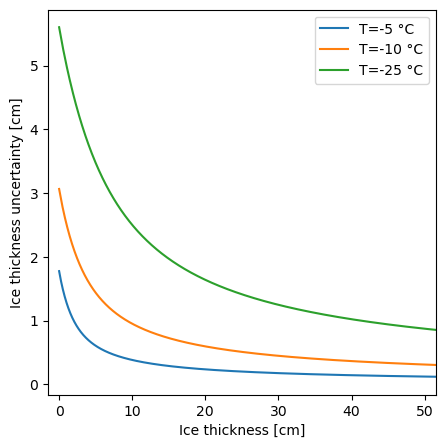

In [7]:
cfdd(temp,duration)=1.33*(-(temp+1.8)*duration)^0.58

days=0:0.01:200

max_ig(T,t)=cfdd(T,t+1)-cfdd(T,t-0)
sittime(sit,temp)=(1/(sit*1.33*(-temp+1.8)))^(1/0.58)
fig=plt.figure(figsize=[5,5])
ax=fig.add_subplot(111)

for temp in [-5,-10,-25]    
    ax.plot(cfdd.(temp,days),max_ig.((temp,),days)*0.68,label="T=$temp °C")
end
ax.legend()
ax.set_xlim(-1.5,51.5)
ax.set_xlabel("Ice thickness [cm]")
ax.set_ylabel("Ice thickness uncertainty [cm]")

#plt.show();
display(fig)

### Propagation of brightness temperature uncertainty
The uncertainty of the CIMR brightness temperatures propagate into uncertainty in the retrieval natively. These are described in {eq}`eq:error` and is a direct result of the sensitivity of the forward model to changes in brightness temperature.

### Uncertainty from full ice cover assumption
The assumption of the full ice coverage originates from the uknown ice concentration. It can occur that a part of the footprint is open water which lowers the brightness temperature and thus make the ice look thinner. This error is accounted for with a $5\ \%$ error on ice concentration. The $p_1$ in for each parameter in {numref}`retrieval parameters` gives the open water tie point, i.e. at 0cm ice thickness. For estimating the uncertainty, these values are mixed with the weight of the ice concentration as

$$ T_{b,h/v}(\text{SIC})=T_{b,h/v}*\text{SIC} + p_{1,h/v}*(1-\text{SIC})$$ 

so that 

$$ σ_\text{SIC} = 1/2 \left(F^{-1}\left(T_{b,h/v}(0.95)\right)+F^{-1}\left(T_{b,h/v}(1.05)\right)\right)
$$ (eq:sicerror)




In [8]:

function owerr(x) #original open water error
    owtbh=65
    owtbv=155
    owi=owtbv/2+owtbh/2
    owq=owtbv-owtbh
    owf=-0.05
    I=fI(x)*(1-owf)+owi*owf
    Q=fQ(x)*(1-owf)+owq*owf
    sit_minus=retrieval_hun(I,Q)
    owf=0.05
    I=fI(x)*(1-owf)+owi*owf
    Q=fQ(x)*(1-owf)+owq*owf
    sit_plus=retrieval_hun(I,Q)
    return ((x-sit_plus)^2+(x-sit_minus)^2)^0.5
end
#ff2_p= [100.2,234.1,12.7]
#qparams = [51.0, 19.4, 31.8, 1.65]  # HBparams


function owerr_2(x,tbs=nothing) #new openwater error
    if tbs==nothing
        tbh,tbv=Fw_TB(x)
    else
        tbh,tbv=tbs
    end
    owtbh=67.7
    owtbv=148.9
    owf=-0.05
    ntbh=(tbh*(1-owf)+(owtbh*owf))
    ntbv=(tbv*(1-owf)+(owtbv*owf))
    owf=0.05
    sit_minus=retrieval(ntbh,ntbv)[1]
    ntbh=(tbh*(1-owf)+(owtbh*owf))
    ntbv=(tbv*(1-owf)+(owtbv*owf))
    sit_plus=retrieval(ntbh,ntbv)[1]
    return ((x-sit_plus)^2+(x-sit_minus)^2)^0.5
end


function retrerr(x,ra)
    IR=fI(x)
    QR=fQ(x)
    ixmax=retrieval_hun(IR+ra*sqrt(2)/2,QR)
    ixmin=retrieval_hun(IR-ra*sqrt(2)/2,QR)
    qxmax=retrieval_hun(IR,QR+ra*sqrt(2))
    qxmin=retrieval_hun(IR,QR-ra*sqrt(2))
    (maximum(x.-[ixmax,ixmin])^2+maximum(x.-[qxmax,qxmin])^2)^0.5
end

sittime(sit,temp)=-(max(0,sit)/1.33)^(1/0.58)/(temp+1.8)

function cfdd_unc(sit)
    t=sittime(sit,-25)
    return (cfdd(-25,t+1)-cfdd(-25,t))*0.68
end

function comb_error(sit)
    return sqrt(cfdd_unc(sit)^2+retrerr(sit,5)^2+owerr(sit)^2)
end

function comb_error_2(sit)
    return sqrt(cfdd_unc(sit)^2+retrieval(Fw_TB(sit)...)[2]+owerr_2(sit)^2)
end

function comb_error_2(sit,tbh,tbv)
    return sqrt(cfdd_unc(sit)^2+retrieval(tbh,tbv)[2]+owerr_2(sit,(tbh,tbv))^2)
end

comb_error_2 (generic function with 2 methods)

### Total uncertainty
The overall uncertainty is calculated as a composition of individual uncertainties in the parameter space, i.e. on ice thickness directly as

$$ 
σ_\text{tot}=\sqrt{\left(σ_{\text{SIC}}^2+σ_\text{growth}^2 + \sigma_\text{retr}^2\right)},
$$ (eq:totaluncertainty)
assuming they are uncorrelated. The indiviual terms as well as the total uncertainty are shown in {numref}`fig:siterrors`. At small ice thickness the largest contribution is from the ice growth error up to about $15\ \text{cm}$. From there, the sensitivity to changes in ice thickness gets smaller and the uncertainty from the SIC takes over the higher contribution.

```{note}
The ice concentration error is not a fixed function of the ice thickness as it is evaluated in the brightness temperature space and thus depends on the input brightness temperatures. 
```

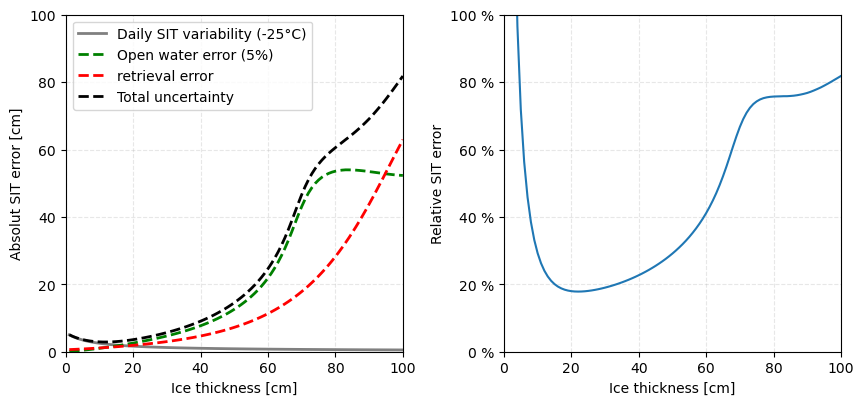

In [9]:
sit=1:100

fig2=plt.figure(figsize=[10,5])#,constrained_layout=true);
ax1=fig2.add_subplot(121);

ax1.plot(sit,cfdd_unc.(sit),label="Daily SIT variability (-25°C)",lw=2,c="gray");

ax1.plot(sit,owerr_2.(sit),label="Open water error (5%)",lw=2,ls="--",c="green");
ax1.plot(sit,[retrieval(Fw_TB(s)...)[2]^0.5 for s in sit],label="retrieval error",lw=2,ls="--",c="red");
ax1.plot(sit,comb_error_2.(sit),label="Total uncertainty",lw=2,ls="--",c="black");
ax1.set_aspect("equal", adjustable="box")

ax1.legend()
ax1.set_xlim(0,sit.stop)
ax1.set_ylim(0,sit.stop)
ax1.set_xlabel("Ice thickness [cm]")
ax1.set_ylabel("Absolut SIT error [cm]")
ax1.grid(linestyle="--",alpha=0.3)

ax2=fig2.add_subplot(122)
ax2.plot(sit,comb_error_2.(sit)./sit.*100);
ax2.set_ylim(0,100)
ax2.set_xlim(0,100)

ticks=0:20:100
ax2.set_yticks(ticks,[(@sprintf "%i %%" i) for i in ticks])
ax2.set_ylabel("Relative SIT error")
ax2.set_xlabel("Ice thickness [cm]")
ax2.set_aspect("equal", adjustable="box")
ax2.grid(linestyle="--",alpha=0.3)

fig2.subplots_adjust(wspace=0.3);

display(fig2)

In [10]:
Qs=20:90
Is=100:270
out=[retrievallm(ii-qq/2,ii+qq/2)[1] for ii=Is,qq=Qs]
out_err=[retrievallm(ii-qq/2,ii+qq/2)[2] for ii=Is,qq=Qs]
out_orig=[retrieval_hun(ii,qq) for ii=Is,qq=Qs];

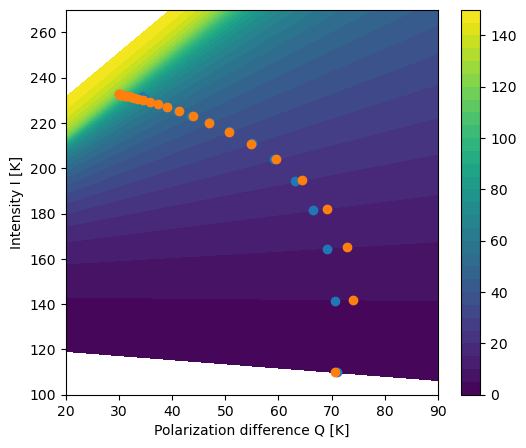

In [11]:

fig3=plt.figure(figsize=[6,5])
ax=fig3.add_subplot(111)
sit=0:5:150

im=ax.contourf(Qs,Is,out.-0.0,levels=sit)

h,v=sit_h.(sit),sit_v.(sit)
allq,alli=v.-h,h./2 .+v./2

ax.plot(fQ.(sit),fI.(sit),lw=0,marker="o",label="I-Q LstSQ")
ax.plot(allq,alli,lw=0,marker="o",label="H-V LstSQ")

ax.set_xlabel("Polarization difference Q [K]")
ax.set_ylabel("Intensity I [K]")

fig3.colorbar(im)

#plt.show(format="png")
display(fig3)